# Adjoint sensitivity method for Kohn Sham equations (supplementary material)
### Evgeny M. Kadilenko (ICKC SB RAS), Roland Grinis (MIPT, GrinisRIT)
#### Assistants: Gregory Dushkin (MIPT), Sabina Abdiganieva (MIPT)

## Theoretical Section.

### Unoccupied electron orbitals are not required for calculation of the total derivative

Let us denote equations and variables, dealing with occupied orbitals ($f_a \neq 0$) using *bar* and with unoccupied orbitals using *tilde*.

Thus matrices can be rewritten in block form:

\begin{equation}
\begin{gathered}
\boldsymbol{C} = 
\begin{pmatrix}
\bar{\boldsymbol{C}} && \widetilde{\boldsymbol{C}}
\end{pmatrix} \\
\boldsymbol{f} =  
\begin{pmatrix}
\bar{\boldsymbol{f}} & \boldsymbol{0} \\
\boldsymbol{0} & \boldsymbol{0}
\end{pmatrix} \\
\boldsymbol{\epsilon} = 
\begin{pmatrix}
\bar{\boldsymbol{\epsilon}} & \boldsymbol{0} \\
\boldsymbol{0} & \widetilde{\boldsymbol{\epsilon}}
\end{pmatrix} 
\end{gathered}
\end{equation}

Using equations from the article we can show:

\begin{equation}
\frac{\partial \vec{\Phi}^{n}}{\partial \vec{C}} = 
2\bigoplus_a \vec{e}_a^T \boldsymbol{C}^T\boldsymbol{S} = 
\begin{pmatrix}
2\bigoplus_{\bar{a}} \vec{e}_{\bar{a}}^T \bar{\boldsymbol{C}}^{T}
\boldsymbol{S} && \boldsymbol{0} \\
\boldsymbol{0} && 2\bigoplus_{\widetilde{a}} \vec{e}_{\widetilde{a}}^T \widetilde{\boldsymbol{C}}^{T}\boldsymbol{S}
\end{pmatrix}
\end{equation}

Therefore, using relation between $\frac{\partial \vec{\Phi}^{KS}}{\partial \vec{\epsilon}}$ and $\frac{\partial \vec{\Phi}^{n}}{\partial \vec{C}}$

\begin{equation}
\frac{\partial \vec{\Phi}^{KS}}{\partial \vec{\epsilon}} = \begin{pmatrix}
-\bigoplus_{\bar{a}} \boldsymbol{S} \bar{\boldsymbol{C}}\vec{e}_{\bar{a}} 
 && \boldsymbol{0} \\
\boldsymbol{0} && -\bigoplus_{\widetilde{a}} \boldsymbol{S}\widetilde{\boldsymbol{C}}\vec{e}_{\widetilde{a}} 
\end{pmatrix}
\end{equation}

\begin{multline}
\frac{\partial \vec{\Phi}^{KS}}{\partial \vec{C}} =
2(\boldsymbol{C}^T \otimes \boldsymbol{I}_{N_{bas}})\boldsymbol{G}(\boldsymbol{C}\boldsymbol{f} \otimes \boldsymbol{I}_{N_{bas}}) +
(\boldsymbol{I}_{N_{orb}} \otimes\boldsymbol{F}) -
(\boldsymbol{\epsilon} \otimes \boldsymbol{S}) = \\
2\left(\begin{pmatrix}
\bar{\boldsymbol{C}}^T \\ \widetilde{\boldsymbol{C}}^T
\end{pmatrix} \otimes \boldsymbol{I}_{N_{bas}}\right)\boldsymbol{G}\left(\begin{pmatrix}
\bar{\boldsymbol{C}} && \widetilde{\boldsymbol{C}}
\end{pmatrix}\begin{pmatrix}
\bar{\boldsymbol{f}} & \boldsymbol{0} \\
\boldsymbol{0} & \boldsymbol{0}
\end{pmatrix} \otimes \boldsymbol{I}_{N_{bas}}\right) +
\bigoplus_a\boldsymbol{F} -
\begin{pmatrix}
\bar{\boldsymbol{\epsilon}} & \boldsymbol{0} \\
\boldsymbol{0} & \widetilde{\boldsymbol{\epsilon}}
\end{pmatrix}  \otimes \boldsymbol{S} = \\
2\begin{pmatrix}
(\bar{\boldsymbol{C}}^T\otimes \boldsymbol{I}_{N_{bas}})\boldsymbol{G}(\bar{\boldsymbol{C}} \bar{\boldsymbol{f}} \otimes \boldsymbol{I}_{N_{bas}}) && \boldsymbol{0}\\
(\widetilde{\boldsymbol{C}}^T\otimes \boldsymbol{I}_{N_{bas}})\boldsymbol{G}(\bar{\boldsymbol{C}} \bar{\boldsymbol{f}} \otimes \boldsymbol{I}_{N_{bas}}) && \boldsymbol{0}
\end{pmatrix}
 +
\begin{pmatrix}
\bigoplus_{\bar{a}} \boldsymbol{F}
 && \boldsymbol{0} \\
\boldsymbol{0} && \bigoplus_{\widetilde{a}} \boldsymbol{F}
\end{pmatrix} -
\begin{pmatrix}
\bar{\boldsymbol{\epsilon}} \otimes \boldsymbol{S} & \boldsymbol{0} \\
\boldsymbol{0} & \widetilde{\boldsymbol{\epsilon}} \otimes \boldsymbol{S}
\end{pmatrix} = \\
\begin{pmatrix}
2(\bar{\boldsymbol{C}}^T\otimes \boldsymbol{I}_{N_{bas}})\boldsymbol{G}(\bar{\boldsymbol{C}} \bar{\boldsymbol{f}} \otimes \boldsymbol{I}_{N_{bas}}) + \bigoplus_{\bar{a}} \boldsymbol{F} - \bar{\boldsymbol{\epsilon}} \otimes \boldsymbol{S} && \boldsymbol{0}\\
2(\widetilde{\boldsymbol{C}}^T\otimes \boldsymbol{I}_{N_{bas}})\boldsymbol{G}(\bar{\boldsymbol{C}} \bar{\boldsymbol{f}} \otimes \boldsymbol{I}_{N_{bas}}) && \bigoplus_{\widetilde{a}} \boldsymbol{F} -
\widetilde{\boldsymbol{\epsilon}} \otimes \boldsymbol{S}
\end{pmatrix}
\end{multline}

\begin{multline}
\frac{\partial \vec{\Phi}}{\partial \vec{X}} = 
\begin{pmatrix}
2(\bar{\boldsymbol{C}}^T\otimes \boldsymbol{I}_{N_{bas}})\boldsymbol{G}(\bar{\boldsymbol{C}} \bar{\boldsymbol{f}} \otimes \boldsymbol{I}_{N_{bas}}) + \bigoplus_{\bar{a}} \boldsymbol{F} - \bar{\boldsymbol{\epsilon}} \otimes \boldsymbol{S} && \boldsymbol{0} && 
-\bigoplus_{\bar{a}} \boldsymbol{S} \bar{\boldsymbol{C}}\vec{e}_{\bar{a}} && \boldsymbol{0} \\
2(\widetilde{\boldsymbol{C}}^T\otimes \boldsymbol{I}_{N_{bas}})\boldsymbol{G}(\bar{\boldsymbol{C}} \bar{\boldsymbol{f}} \otimes \boldsymbol{I}_{N_{bas}}) && \bigoplus_{\widetilde{a}} \boldsymbol{F} -
\widetilde{\boldsymbol{\epsilon}} \otimes \boldsymbol{S} && \boldsymbol{0} && 
-\bigoplus_{\widetilde{a}} \boldsymbol{S}\widetilde{\boldsymbol{C}}\vec{e}_{\widetilde{a}} \\
2\bigoplus_{\bar{a}} \vec{e}_{\bar{a}}^T \bar{\boldsymbol{C}}^{T}
\boldsymbol{S} && \boldsymbol{0} && \boldsymbol{0} && \boldsymbol{0} \\
\boldsymbol{0} && 2\bigoplus_{\widetilde{a}} \vec{e}_{\widetilde{a}}^T \widetilde{\boldsymbol{C}}^{T}\boldsymbol{S} && \boldsymbol{0} && \boldsymbol{0}
\end{pmatrix}
\end{multline}

\begin{equation}
\frac{\partial E}{ \partial \vec{C}} =
2 \cdot \text{vec}(\boldsymbol{F}
\boldsymbol{C}\boldsymbol{f} )^T = 2 \cdot \text{vec}\left(\boldsymbol{F}
\begin{pmatrix}
\bar{\boldsymbol{C}} && \widetilde{\boldsymbol{C}}
\end{pmatrix}
\begin{pmatrix}
\bar{\boldsymbol{f}} & \boldsymbol{0} \\
\boldsymbol{0} & \boldsymbol{0}
\end{pmatrix} \right)^T =
\begin{pmatrix}
2 \cdot\text{vec}(\boldsymbol{F}\bar{\boldsymbol{C}}\bar{\boldsymbol{f}})^T && \vec{0}^T
\end{pmatrix}
\end{equation}

Thus:

\begin{equation}
\frac{\partial E}{ \partial \vec{X}} =  
\begin{pmatrix}
2 \cdot\text{vec}(\boldsymbol{F}\bar{\boldsymbol{C}}\bar{\boldsymbol{f}})^T && \vec{0}^T && \vec{0}^T && \vec{0}^T
\end{pmatrix}
\end{equation}

Adjoint vector:

\begin{equation}
\vec{\lambda} = \begin{pmatrix}
\vec{\bar{\lambda}}^{KS} \\
\vec{\widetilde{\lambda}}^{KS} \\
\vec{\bar{\lambda}}^n \\
\vec{\widetilde{\lambda}}^n
\end{pmatrix}
\end{equation}

They produce two matrix equations for $\vec{\widetilde{\lambda}}^{KS}$ and $\vec{\widetilde{\lambda}}^n$:

\begin{equation}
\left(\bigoplus_{\widetilde{a}} \boldsymbol{F} -
\widetilde{\boldsymbol{\epsilon}} \otimes \boldsymbol{S}\right)\vec{\widetilde{\lambda}}^{KS} + 2 \left(\bigoplus_{\widetilde{a}} \boldsymbol{S}\widetilde{\boldsymbol{C}}\vec{e}_{\widetilde{a}}\right)\vec{\widetilde{\lambda}}^n = \vec{0}
\end{equation}

\begin{equation}
-\left(\bigoplus_{\widetilde{a}}
\vec{e}_{\widetilde{a}}^T
\widetilde{\boldsymbol{C}}^T\boldsymbol{S}\right)\vec{\widetilde{\lambda}}^{KS} = \vec{0}
\end{equation}

At first, multiply the first equation by $(\boldsymbol{I}_{N_{orb}^{unocc}} \otimes \widetilde{\boldsymbol{C}}^T)$ from the left:

\begin{equation*}
\begin{gathered}
(\boldsymbol{I}_{N_{orb}^{unocc}} \otimes \widetilde{\boldsymbol{C}}^T)\left(\bigoplus_{\widetilde{a}} \boldsymbol{F} -
\widetilde{\boldsymbol{\epsilon}} \otimes \boldsymbol{S}\right)\vec{\widetilde{\lambda}}^{KS} + 2(\boldsymbol{I}_{N_{orb}^{unocc}} \otimes \widetilde{\boldsymbol{C}}^T) \left(\bigoplus_{\widetilde{a}} \boldsymbol{S}\widetilde{\boldsymbol{C}}\vec{e}_{\widetilde{a}}\right)\vec{\widetilde{\lambda}}^n = \vec{0} \\
\left(\bigoplus_{\widetilde{a}} \widetilde{\boldsymbol{C}}^T\boldsymbol{F} -
(\boldsymbol{I}_{N_{orb}^{unocc}} \otimes \widetilde{\boldsymbol{C}}^T)(\widetilde{\boldsymbol{\epsilon}} \otimes \boldsymbol{S})\right)\vec{\widetilde{\lambda}}^{KS} + 2 \left(\bigoplus_{\widetilde{a}}\widetilde{\boldsymbol{C}}^T \boldsymbol{S}\widetilde{\boldsymbol{C}}\vec{e}_{\widetilde{a}}\right)\vec{\widetilde{\lambda}}^n = \vec{0} \\
\end{gathered}
\end{equation*}

\begin{equation*}
\begin{gathered}
\left(\bigoplus_{\widetilde{a}} \widetilde{\boldsymbol{\epsilon}}\widetilde{\boldsymbol{C}}^T\boldsymbol{S} -
(\widetilde{\boldsymbol{\epsilon}} \otimes \widetilde{\boldsymbol{C}}^T\boldsymbol{S})\right)\vec{\widetilde{\lambda}}^{KS} + 2 \left(\bigoplus_{\widetilde{a}}\vec{e}_{\widetilde{a}}\right)\vec{\widetilde{\lambda}}^n = \vec{0} \\
\bigoplus_{\widetilde{a}} \left(\widetilde{\boldsymbol{\epsilon}}\widetilde{\boldsymbol{C}}^T\boldsymbol{S} -
\epsilon_{\widetilde{a}}
\widetilde{\boldsymbol{C}}^T\boldsymbol{S}\right)\vec{\widetilde{\lambda}}^{KS} + 2 \left(\bigoplus_{\widetilde{a}}\vec{e}_{\widetilde{a}}\right)\vec{\widetilde{\lambda}}^n = \vec{0}
\end{gathered}
\end{equation*}

then by $\bigoplus_{\widetilde{a}} \vec{e}_{\widetilde{a}}^T$ :

\begin{equation}
\begin{gathered}
\bigoplus_{\widetilde{a}} \vec{e}_{\widetilde{a}}^T\left(\widetilde{\boldsymbol{\epsilon}}\widetilde{\boldsymbol{C}}^T\boldsymbol{S} -
\epsilon_{\widetilde{a}}
\widetilde{\boldsymbol{C}}^T\boldsymbol{S}\right)\vec{\widetilde{\lambda}}^{KS} + 2 \left(\bigoplus_{\widetilde{a}}\vec{e}_{\widetilde{a}}^T\vec{e}_{\widetilde{a}}\right)\vec{\widetilde{\lambda}}^n = \vec{0} \\ 
\bigoplus_{\widetilde{a}} \left(\epsilon_{\widetilde{a}}\vec{e}_{\widetilde{a}}^T\widetilde{\boldsymbol{C}}^T\boldsymbol{S} -
\epsilon_{\widetilde{a}}\vec{e}_{\widetilde{a}}^T
\widetilde{\boldsymbol{C}}^T\boldsymbol{S}\right)\vec{\widetilde{\lambda}}^{KS} + 2 \boldsymbol{I}_{N_{orb}^{unocc}}\vec{\widetilde{\lambda}}^n = \vec{0} \\
\vec{\widetilde{\lambda}}^n = \vec{0}
\end{gathered}
\end{equation}

So, we left with:

\begin{equation}
\left(\bigoplus_{\widetilde{a}} \boldsymbol{F} -
\widetilde{\boldsymbol{\epsilon}} \otimes \boldsymbol{S}\right)\vec{\widetilde{\lambda}}^{KS} = \vec{0}
\end{equation}

or, only for block ${\widetilde{a}}$:

\begin{equation}
\left(\boldsymbol{F} -
{\epsilon}_{\widetilde{a}} \boldsymbol{S}\right)\vec{\widetilde{\lambda}}_{\widetilde{a}}^{KS} = \vec{0}
\end{equation}

Let us take a derivative with respect to ${\epsilon}_{\widetilde{a}}$:

\begin{equation}
- \boldsymbol{S}\vec{\widetilde{\lambda}}_{\widetilde{a}}^{KS} = \vec{0}
\end{equation}

$\boldsymbol{S}$ is a positive-definite matrix, thus it is invertable:

\begin{equation}
\begin{gathered}
- \boldsymbol{S}^{-1}\boldsymbol{S}\vec{\widetilde{\lambda}}_{\widetilde{a}}^{KS} = \boldsymbol{S}^{-1}\vec{0} \\
\vec{\widetilde{\lambda}}_{\widetilde{a}}^{KS} = \vec{0}
\end{gathered}
\end{equation}

Because $\widetilde{a}$ was arbitary, the whole vector is zero:

\begin{equation}
\vec{\widetilde{\lambda}}^{KS} = \vec{0}
\end{equation}

It is easy to show, that:

\begin{equation}
\vec{\lambda}^T\frac{\partial \vec{\Phi}}{\partial \vec{\Theta}} =
\begin{pmatrix}
\vec{\bar{\lambda}}^{KS,T} & 0 & \vec{\bar{\lambda}}^{n,T} & 0
\end{pmatrix}
\begin{pmatrix}
\frac{\partial\vec{\bar{\Phi}}^{KS}}{\partial \vec{\Theta}} \\
\frac{\partial\vec{\widetilde{\Phi}}^{KS}}{\partial \vec{\Theta}} \\
0 \\
0
\end{pmatrix} = \vec{\bar{\lambda}}^{KS,T}\frac{\partial\vec{\bar{\Phi}}^{KS}}{\partial \vec{\Theta}} = 
\begin{pmatrix}
\vec{\bar{\lambda}}^{KS,T} & \vec{\bar{\lambda}}^{n,T}
\end{pmatrix}
\begin{pmatrix}
\frac{\partial\vec{\bar{\Phi}}^{KS}}{\partial \vec{\Theta}} \\
0
\end{pmatrix} = 
\vec{\bar{\lambda}}^T\frac{\partial \vec{\bar{\Phi}}}{\partial \vec{\Theta}}
\end{equation}

\begin{equation}
\left(\frac{\partial \vec{\bar{\Phi}}}{\partial \vec{\bar{X}}}\right)^T\vec{\bar{\lambda}} = \left(\frac{\partial E}{\partial \vec{\bar{X}}}\right)^T
\end{equation}

In practice, this means that we can use $\vec{\bar{X}}$ and $\vec{\bar{\Phi}}$ instead of $\vec{X}$ and $\vec{\Phi}$, respectively. It allows us to significantly speed up calculation of adjoint vector.

### $\partial\vec{\Phi}^{KS}(\boldsymbol{C},\boldsymbol{\epsilon};\;\vec{\Theta}) / \partial\vec{C}$ is symmetric for UKS-LDA and RKS-LDA

We want to show that $\boldsymbol{\alpha}$ is symmetric under certain conditions, namely, if we deal with situation 

\begin{equation}
\boldsymbol{\bar{f}}=\bar{f}\boldsymbol{I}_{N_{orb}^{occ}}
\end{equation}

It occurs in restricted (RKS, $\bar{f}=2$) and unrestricted Kohn-Sham (UKS, $\bar{f}=1$) methods.

At first, we have to show, that functional derivative from Hamiltonian with respect to electronic density in the case of LDA:

\begin{equation}
\frac{\delta 
 H^{LDA}[\rho](\vec{r};\;\vec{\Theta})
}{\delta \rho(\vec{r'})} = \frac{1}{|\vec{r}-\vec{r'}|}
+
\frac{\partial V_{XC}(\rho;\;\vec{\Theta})}{\partial \rho}\delta(\vec{r} - \vec{r'})
\end{equation}

is invariant to $r \leftrightarrow r'$ exchange:

\begin{equation}
\frac{\delta 
 H^{LDA}[\rho](\vec{r'};\;\vec{\Theta})
}{\delta \rho(\vec{r})} = \frac{1}{|\vec{r'}-\vec{r}|}
+
\frac{\partial V_{XC}(\rho;\;\vec{\Theta})}{\partial \rho}\delta(\vec{r'} - \vec{r}) = \frac{1}{|\vec{r}-\vec{r'}|}
+
\frac{\partial V_{XC}(\rho;\;\vec{\Theta})}{\partial \rho}\delta(\vec{r} - \vec{r'}) = \frac{\delta 
 H^{LDA}[\rho](\vec{r};\;\vec{\Theta})
}{\delta \rho(\vec{r'})}
\end{equation}

It helps us to show $\boldsymbol{G} = \boldsymbol{G}^T$:

\begin{equation}
\begin{aligned}
\boldsymbol{G}^T = &\left(\iint (\vec{\chi}(\vec{r}) \otimes\vec{\chi}(\vec{r}))\frac{\delta 
 H[\rho](\vec{r};\;\vec{\Theta})
}{\delta \rho(\vec{r'})}(\vec{\chi}^T(\vec{r'}) \otimes\vec{\chi}^T(\vec{r'}))d\vec{r}d\vec{r'}\right)^T \\
&\left(\iint (\vec{\chi}(\vec{r'}) \otimes\vec{\chi}(\vec{r'}))\frac{\delta 
 H[\rho](\vec{r};\;\vec{\Theta})
}{\delta \rho(\vec{r'})}(\vec{\chi}^T(\vec{r}) \otimes\vec{\chi}^T(\vec{r})) d\vec{r}d\vec{r'}\right) = \\
&\left(\iint (\vec{\chi}(\vec{r}) \otimes\vec{\chi}(\vec{r}))\frac{\delta 
 H[\rho](\vec{r'};\;\vec{\Theta})
}{\delta \rho(\vec{r})}(\vec{\chi}^T(\vec{r'}) \otimes\vec{\chi}^T(\vec{r'})) d\vec{r'}d\vec{r}\right) = \\
&\left(\iint (\vec{\chi}(\vec{r}) \otimes\vec{\chi}(\vec{r}))\frac{\delta 
 H[\rho](\vec{r};\;\vec{\Theta})
}{\delta \rho(\vec{r'})}(\vec{\chi}^T(\vec{r'}) \otimes\vec{\chi}^T(\vec{r'})) d\vec{r}d\vec{r'}\right) = \boldsymbol{G}
\end{aligned}
\end{equation}

Now it is clear that

\begin{equation}
\begin{gathered}
\frac{\partial\vec{\Phi}^{KS}(\boldsymbol{C},\boldsymbol{\epsilon};\;\vec{\Theta})}{\partial \vec{C}} = 2\bar{f}(\boldsymbol{\bar{C}}^T \otimes \boldsymbol{I}_{N_{bas}})\boldsymbol{G}(\boldsymbol{\bar{C}} \otimes \boldsymbol{I}_{N_{bas}}) +
(\boldsymbol{I}_{N_{orb}^{occ}} \otimes\boldsymbol{F}) -
(\boldsymbol{\bar{\epsilon}} \otimes \boldsymbol{S})
\end{gathered}
\end{equation}

is symmetric. This fact may help us to speed up calculation of this matrix.


## Computational Section.

### Preparing the globals

#### Imports

In [1]:
import dqc
import pyscf
from pyscf import gto, dft, scf, cc
import numpy
import torch
import xitorch as xt
from math import pi
import sys 
import time
import pandas as pd
from IPython.display import display, HTML, Math
import numba as nb
import matplotlib.pyplot as plt
from matplotlib import ticker
import functools
from ast import literal_eval
import cpuinfo
import psutil

#### Hardware and software specifications:

In [2]:
print(f'PySCF version: {pyscf.__version__}')
print(f'DQC version: {dqc.__version__}')

PySCF version: 2.1.1
DQC version: 0.1.0


In [3]:
print(f'Total RAM: {psutil.virtual_memory().total / (2**30)} Gb')
print(f'CPU: {cpuinfo.get_cpu_info()["brand_raw"]}')

Total RAM: 251.88466262817383 Gb
CPU: Intel(R) Xeon(R) CPU E5-2630 v2 @ 2.60GHz


#### LDA constants:
We use the basic power-type LDA functional with density
$$
\epsilon \left[ \rho \right] = a \cdot \rho ^ p
$$
as example.

In [4]:
LDA_factor = -3.0/4.0 * (3.0 / pi)**(1.0/3.0)
LDA_power = 4.0/3.0

### Correctness test: energy

#### Custom functionals

Here we take a look at the ways to implement an LDA functional and compare them to some built-in methods.

#### PySCF

PySCF accepts custom functionals as Python functions

In [5]:
def PySCF_LDA_constructor(a, p):
    def eval_xc(xc_code, rho, *args, **kwargs):
        numpy.nan_to_num(rho) # delete NaNs
        rho.clip(0) # delete negative numbers
        exc = a * rho ** (p - 1.0)
        vrho = a * p * rho ** (p - 1.0)
        vxc = (vrho, None, None, None)
        return exc, vxc, None, None
    return eval_xc

In [6]:
def pyscf_custom_LDA_calculator_of_energy(_mol, a = LDA_factor, p = LDA_power):
    scf_mol = gto.M(atom=_mol, basis="6-31G", unit="Bohr", verbose=0)
    
    # Timer
    start = time.time()
    calc_scf = dft.RKS(scf_mol)
    calc_scf = calc_scf.define_xc_(PySCF_LDA_constructor(a, p), "LDA")
    energy = calc_scf.kernel()
    dur = time.time() - start
    
    return energy, calc_scf.converged, dur

#### Built-in functional
To compare the results, we would use PySCF's built-in implementation of the same functional

In [7]:
def pyscf_builtin_LDA_calculator_of_energy(_mol):
    scf_mol = gto.M(atom=_mol, basis="6-31G", unit="Bohr", verbose=0)
    
    #Timer
    start = time.time()
    calc_scf = dft.RKS(scf_mol)
    calc_scf.xc = "lda," # Built-in LDA functional implementation
    energy = calc_scf.kernel()
    dur = time.time() - start
    
    return energy, calc_scf.converged, dur

#### CCSD(T)

In [8]:
def pyscf_CCSD_T_calculator_of_energy(_mol):
    scf_mol = gto.M(atom=_mol, basis="6-31G", unit="Bohr", verbose=0)
    
    #Timer
    start = time.time()
    hf_ = scf.HF(scf_mol)
    hf = hf_.run()
    calc_scf = cc.CCSD(hf)
    _en = calc_scf.kernel()
    et = calc_scf.ccsd_t()
    energy = calc_scf.e_tot + et
    dur = time.time() - start
    
    return energy, calc_scf.converged, dur

#### DQC

DQC accepts custom functionals as objects of classes derived from `dqc.xc.CustomXC`

In [9]:
class DQC_LDA_contructor(dqc.xc.CustomXC):
    def __init__(self, a_par, p_par):
        super().__init__()
        self.a_par = a_par
        self.p_par = p_par
        self.number_of_parameters = 2

    @property
    def family(self):
        # 1 for LDA, 2 for GGA, 4 for MGGA
        return 1

    def get_edensityxc(self, densinfo):
        # densinfo has up and down components
        if isinstance(densinfo, dqc.utils.SpinParam):
            # spin-scaling of the exchange energy
            return 0.5 * (self.get_edensityxc(densinfo.u * 2) + self.get_edensityxc(densinfo.d * 2))
        else:
            rho = densinfo.value.abs() + 1e-15  # safeguarding from nan
            return self.a_par * rho ** self.p_par
        
    def get_edensityxc_derivative(self, densinfo, number_of_parameter):
        # densinfo has up and down components
        if isinstance(densinfo, dqc.utils.SpinParam):
            # spin-scaling of the exchange energy
            return 0.5 * (self.get_edensityxc_derivative(densinfo.u * 2, number_of_parameter) 
                          + self.get_edensityxc_derivative(densinfo.d * 2, number_of_parameter))
        else:
            rho = densinfo.value.abs() + 1e-15  # safeguarding from nan
            if number_of_parameter == 0: # parameter a
                return rho ** self.p_par
            elif number_of_parameter == 1: # parameter p
                return self.a_par * torch.log(rho) * rho ** self.p_par

In [10]:
def dqc_nograd_custom_LDA_calculator_of_energy(_mol, a = LDA_factor, p = LDA_power):
    with torch.no_grad():
        atmozs, atomposs = dqc.parse_moldesc(_mol)
        dqc_mol = dqc.Mol((atmozs, atomposs), basis="6-31G")

        #Timer
        start = time.time()
        a_par = torch.nn.Parameter(torch.tensor(a, dtype=torch.double))
        p_par = torch.nn.Parameter(torch.tensor(p, dtype=torch.double))
        qc = dqc.KS(dqc_mol, xc=DQC_LDA_contructor(a_par, p_par))

        energy_tensor = qc.run().energy()
        energy = energy_tensor.item()
        dur = time.time() - start

    return energy_tensor.item(), True, dur

#### Comparison test

Let's compare all of the above methods (also, for convenience, all of the results are compiled at the end of the notebook in tables).

In [11]:
molecules_for_correctness_tests = {
    "h2"       :  """
                  H 0 0 0; H 1.4 0 0
                  """
    ,
    "n2"       :  """
                  N 0 0 0; N 2.07 0 0
                  """
    ,
    "water"    : """
                 O        0.000000000      0.000000000      0.000000000;
                 H        0.000000000      1.434938863      1.126357947;
                 H        0.000000000     -1.434938863      1.12635794
                 """
     ,
    "ammonia" : """
                 N  0.000  0.000  0.000;
                 H  0.000 -1.772 -0.721; 
                 H  1.535  0.886 -0.721; 
                 H -1.535  0.886 -0.721
                 """
    ,
    "benzene" : """
                C        0.598362921      0.000000000     -4.742986733;
                C       -0.557705772     -0.354690359     -4.044822733;
                C        1.754431614      0.354690359     -4.044822733;
                H       -1.457130878     -0.630640582     -4.587995733;
                H        2.653856720      0.630640582     -4.587995733;
                C       -0.557705772     -0.354690359     -2.648492733;
                C        1.754431614      0.354690359     -2.648492733;
                H       -1.457130878     -0.630640582     -2.105319733;
                H        2.653856720      0.630640582     -2.105319733;
                C        0.598362921      0.000000000     -1.950328733;
                H        0.598362921      0.000000000     -0.863981733;
                H        0.598362921      0.000000000     -5.829333733
                """
}

In [12]:
energy_correctness_results = {
    "pyscf_builtin":    {},
    "pyscf_custom":     {},
    "pyscf_ccsdt":      {},
    "dqc_nograd":       {},
}

for data_of_method in energy_correctness_results.values():
    for mol_name in molecules_for_correctness_tests:
        data_of_method[mol_name] = {}

In [13]:
def print_results_energy(mol_name, method_name, e, c, d):
    print(f"For {mol_name} molecule and {method_name} method: energy={e} Eh, duration={d} s")
    if not c:
        print(f"Calculation for {mol_name} and method {method_name} did not converge", file=sys.stderr)

def print_and_save_results_energy(mol_name, method_name, e, c, d):
    print_results_energy(mol_name, method_name, e, c, d)
    energy_correctness_results[method_name][mol_name]["energy"] = e
    energy_correctness_results[method_name][mol_name]["converged"] = c
    energy_correctness_results[method_name][mol_name]["time"] = d

for mol_name, mol in molecules_for_correctness_tests.items():
    e, c, d = pyscf_CCSD_T_calculator_of_energy(mol)
    print_and_save_results_energy(mol_name, "pyscf_ccsdt", e, c, d)
    
    e, c, d = pyscf_builtin_LDA_calculator_of_energy(mol)
    print_and_save_results_energy(mol_name, "pyscf_builtin", e, c, d)

    e, c, d = pyscf_custom_LDA_calculator_of_energy(mol, LDA_factor, LDA_power)
    print_and_save_results_energy(mol_name, "pyscf_custom", e, c, d)

    e, c, d = dqc_nograd_custom_LDA_calculator_of_energy(mol, LDA_factor, LDA_power)
    print_and_save_results_energy(mol_name, "dqc_nograd", e, c, d)
    
    print("---><---")

For h2 molecule and pyscf_ccsdt method: energy=-1.1516791660767665 Eh, duration=0.46305227279663086 s
For h2 molecule and pyscf_builtin method: energy=-1.0386177856738819 Eh, duration=0.4423105716705322 s
For h2 molecule and pyscf_custom method: energy=-1.0386177856738819 Eh, duration=0.594165563583374 s
For h2 molecule and dqc_nograd method: energy=-1.0386170699228434 Eh, duration=0.2612292766571045 s
---><---
For n2 molecule and pyscf_ccsdt method: energy=-109.10264680034624 Eh, duration=0.30572962760925293 s
For n2 molecule and pyscf_builtin method: energy=-107.6394735383106 Eh, duration=0.9274556636810303 s
For n2 molecule and pyscf_custom method: energy=-107.63947353831045 Eh, duration=0.8847291469573975 s
For n2 molecule and dqc_nograd method: energy=-107.63947314633589 Eh, duration=0.19311904907226562 s
---><---
For water molecule and pyscf_ccsdt method: energy=-76.12064120720741 Eh, duration=0.2074418067932129 s
For water molecule and pyscf_builtin method: energy=-75.1547053402

The results of calculations with custom LDA functionals are in excellent agreement with the results of calculations with builtin LDA functional.

### Existing methods for calculation of energy derivatives.

The basic way to compute energy derivatives is to use finite differences. DQC also allows to make use of PyTorch's `autograd`. We will also explore the adjoint sensitivity method.

From now on, all of the calculations will rely on user defined functionals.

### Finite differences

Calculating derivatives via finite difference is straighforward once there is a way to calculate energy:

In [14]:
def finite_differences_calculator_of_derivatives(method, _mol, a, p, bump_factor=0.00001):
    c = True
    en, c1, dur = method(_mol, a, p)
    c &= c1
    da = a * bump_factor
    dp = p * bump_factor

    en_da, c1, dur1 = method(_mol, a + da, p)
    c &= c1
    en_dp, c1, dur2 = method(_mol, a, p + dp)
    c &= c1

    dea = (en_da - en) / da
    dep = (en_dp - en) / dp

    if not c:
        print(f"One of finite difference computations for {_mol_name} didn't converge with {method}", file=sys.stderr)

    return dea, dep, dur + dur1 + dur2

### DQC and `torch.autograd`

In [15]:
def dqc_autograd_calculator_of_derivatives(_mol, a, p):
    atmozs, atomposs = dqc.parse_moldesc(_mol)
    dqc_mol = dqc.Mol((atmozs, atomposs), basis="6-31G")
    
    #Timer
    start = time.time()
    a_par = torch.nn.Parameter(torch.tensor(a, dtype=torch.double))
    p_par = torch.nn.Parameter(torch.tensor(p, dtype=torch.double))
    qc = dqc.KS(dqc_mol, xc=DQC_LDA_contructor(a_par, p_par))
    
    energy_tensor = qc.run().energy()
    grad = torch.autograd.grad(energy_tensor, (a_par, p_par))
    dur = time.time() - start

    return grad[0].item(), grad[1].item(), dur

### New method: Adjoint sensitivity method

#### Full algorithm in DQC and pytorch

#### Preparing for calculation

Initialize the system, DQC, and set up some variables

In [16]:
from dqc.utils.datastruct import SpinParam, ValGrad

mol_name_ = "water"

a_par = torch.nn.Parameter(torch.tensor(LDA_factor, dtype=torch.double))
p_par = torch.nn.Parameter(torch.tensor(LDA_power, dtype=torch.double))
aj_mol = molecules_for_correctness_tests[mol_name_]
atmozs, atomposs = dqc.parse_moldesc(aj_mol)
dqc_mol = dqc.Mol((atmozs, atomposs), basis="6-31G")
qc = dqc.KS(dqc_mol, xc=DQC_LDA_contructor(a_par, p_par)).run()

In [17]:
def _symm(scp: torch.Tensor):
    # forcely symmetrize the tensor
    return (scp + scp.transpose(-2, -1)) * 0.5

dm = qc._dm.detach().clone()
noccorb = qc._engine.hf_engine._norb
nallorb = qc.get_system().get_hamiltonian().nao
fockian = qc._engine.dm2scp(dm).detach().clone()

def eigendecomposition(hf_engine):
    if not hf_engine._polarized:
        fock = xt.LinearOperator.m(_symm(fockian), is_hermitian=True)
        return hf_engine.diagonalize(fock, noccorb)
    else:
        fock_u = xt.LinearOperator.m(_symm(fockian[0]), is_hermitian=True)
        fock_d = xt.LinearOperator.m(_symm(fockian[1]), is_hermitian=True)
        return hf_engine.diagonalize(hf_engine, SpinParam(u=fock_u, d=fock_d))

energies, coefficients = eigendecomposition(qc._engine.hf_engine)
orboccs = qc._engine.orb_weight.detach().clone()

First, derivatives from energy:

#### Calculating $\frac{\partial E[\rho](\vec{\theta})}{\partial \textbf{C}}$

Only canonical (i.e. eigenfunctions of fockian) orbitals can be used:
$$ \frac{\partial E[\rho](\vec{\theta})}{\partial C_{bj}} = 2f_b \sum_i C_{bi}F_{ij} = 2f_b \epsilon_b C_{bj}$$
so
$$ \frac{\partial E[\rho](\vec{\theta})}{\partial \textbf{C}} = 2\textbf{f}\epsilon\textbf{C}$$
$\epsilon$ here is matrix: $\epsilon_{ab}=\delta_{ab}\epsilon_a$

In [18]:
dE_wrt_dC = 2 * torch.einsum("b,ib,ij->bj", orboccs, coefficients, fockian)

#### Calculating $\frac{\partial E[\rho](\vec{\theta})}{\partial \vec{\epsilon}}$

$$\frac{\partial E[\rho](\vec{\theta})}{\partial \epsilon_{b}} = 0$$ for all $\epsilon_b$. So:

In [19]:
dE_wrt_depsilon = torch.zeros(noccorb)

Then, derivatives from normalization equations:

#### Calculating $\frac{\partial \vec{\Phi}^{n}(\textbf{C})}{\partial \textbf{C}}$

$$\frac{\partial \Phi^{n}_{a}(\textbf{C})}{\partial C_{ck}} = 2\delta_{ac}C_{ck}$$

In [20]:
occupied_orbitals_kronecker = torch.eye(noccorb)
dnorm_wrt_dC = 2 * torch.einsum("ac,kc->kac", occupied_orbitals_kronecker, coefficients)

#### Calculating $\frac{\partial \vec{\Phi}^{n}(\textbf{C})}{\partial \vec{\epsilon}}$
$$\frac{\partial \Phi^{n}_{a}(\textbf{C})}{\partial \epsilon_b} = 0$$

In [21]:
dnorm_wrt_depsilon = torch.zeros((noccorb, noccorb))

Derivatives from Kohn-Sham equations:

#### Calculating $\frac{\partial {\Phi}^{KS}(\textbf{C};\;\vec{\theta})}{\partial \textbf{C}}$

$$G_{Cou, ijkl} = \iint b_i(\vec{r}) \frac{b_k(\vec{r'})b_l(\vec{r'})}{|\vec{r}-\vec{r'}|} b_j(\vec{r})d\vec{r'}d\vec{r}$$
$$G_{XC, ijkl} = 
\int b_i(\vec{r}) b_k(\vec{r}) \frac{\partial V_{XC}[\rho](\vec{r};\;\vec{\theta})}{\partial \rho(\vec{r})}b_l(\vec{r})b_j(\vec{r})d\vec{r}$$
$$\frac{\partial \Phi^{KS}_{ia}(\textbf{C};\;\vec{\theta})}{\partial C_{ck}} = 
(F_{ik}[\rho](\vec{\theta}) - \epsilon_c\delta_{ik})\delta_{ac} +
2f_c\sum_j \sum_{l}C_{cl}\left(G_{Cou,ijkl} + G_{XC,ijkl}\right)C_{aj}
$$

First term:

In [22]:
all_orbitals_kronecker = torch.eye(nallorb)
dKS_wrt_dC_first_term = torch.einsum(
                                            "ik,ac->iakc",
                                            fockian,
                                            occupied_orbitals_kronecker
                                        )
dKS_wrt_dC_first_term -= torch.einsum(
                                            "c,ik,ac->iakc",
                                            energies,
                                            all_orbitals_kronecker,
                                            occupied_orbitals_kronecker
                                        )

Second term (fourDtensor loses symmetry of XC-tensor):

In [23]:
four_center_elrep_tensor = torch.einsum(
                "ijkl,lc,ja->iakc",
                qc._engine.hamilton.el_mat.detach().clone(),
                coefficients,
                coefficients
            )

def get_dvxc_wrt_dro_xc(xc, densinfo):
    # mark the densinfo components as requiring grads
    with xc._enable_grad_densinfo(densinfo):
        with torch.enable_grad():
            edensity = xc.get_edensityxc(densinfo)  # (*BD, ngrid)
        grad_outputs = torch.ones_like(edensity)
        # print(f'edensity {edensity.shape}')
        grad_enabled = torch.is_grad_enabled()

        if not isinstance(densinfo, ValGrad):  # polarized case
            raise NotImplementedError("polarized case is not implemented")
        else:  # unpolarized case
            if xc.family == 1:  # LDA
                # Here we are taking autograd.grad derivative twice:
                potinfo, = torch.autograd.grad(
                    edensity, densinfo.value, create_graph=grad_enabled,
                    grad_outputs=grad_outputs)
                # print(f'potinfo {potinfo.shape}')
                derivative_of_potinfo_wrt_ro, = torch.autograd.grad(
                    potinfo, densinfo.value, grad_outputs=grad_outputs)
                return ValGrad(value=derivative_of_potinfo_wrt_ro)
            else:  # GGA and others
                raise NotImplementedError("Default dvxc wrt dro for this family is not implemented")

@nb.njit(parallel=True)
def _four_term_integral(m, b, o):
    N = b.shape[1]  # size of basis set
    n = o.shape[1]  # number of occupied orbitals
    R = m.shape[0]  # size of grid
    res = numpy.zeros((N, n, N, n))
    for i in nb.prange(N):
        for a in range(n):
            for k in range(i+1):
                for c in range(a+1):
                    for r in range(R):
                        value = m[r] * b[r, i] * o[r, a] * b[r, k] * o[r, c]
                        res[i, a, k, c] += value
                        if a != c:
                            res[i, c, k, a] += value
                            if i != k:
                                res[k, a, i, c] += value
                                res[k, c, i, a] += value
                        elif i != k:
                            res[k, a, i, c] += value
    return res

def get_dvxc_wrt_dro_from_derivative_of_potinfo_wrt_ro(hamiltonian, derivative_of_potinfo_wrt_ro: ValGrad):
    print(f'started the four term integral computation for {hamiltonian.basis.shape}...')
    molecular_orbitals_at_grid = hamiltonian.basis @ coefficients
    derivative_of_potinfo_wrt_ro_dvolume = derivative_of_potinfo_wrt_ro.value * hamiltonian.dvolume
    mat = _four_term_integral(derivative_of_potinfo_wrt_ro_dvolume.numpy(),
                                hamiltonian.basis.numpy(),
                                molecular_orbitals_at_grid.numpy())
    return torch.from_numpy(mat)

def construct_vxc_derivative_tensor(hamiltonian, dm):
    densinfo = SpinParam.apply_fcn(lambda dm_: hamiltonian._dm2densinfo(dm_), dm)  # value: (*BD, ngrid)
    print(f'density info {densinfo.value.shape}')
    derivative_of_potinfo_wrt_ro = get_dvxc_wrt_dro_xc(hamiltonian.xc, densinfo)  # value: (*BD, ngrid)
    dvxc_wrt_dro = get_dvxc_wrt_dro_from_derivative_of_potinfo_wrt_ro(hamiltonian,
                                                                                derivative_of_potinfo_wrt_ro)
    return dvxc_wrt_dro

fourDtensor = four_center_elrep_tensor + \
                construct_vxc_derivative_tensor(qc._engine.hamilton, dm)
dKS_wrt_dC_second_term = 2 * torch.einsum("c,iakc->iakc", orboccs, fourDtensor)

density info torch.Size([52366])
started the four term integral computation for torch.Size([52366, 13])...


In [24]:
dKS_wrt_dC = dKS_wrt_dC_first_term + dKS_wrt_dC_second_term

#### Calculating $\frac{\partial \Phi^{KS}(\textbf{C};\;\vec{\theta})}{\partial \vec{\epsilon}}$

$$\frac{\partial \Phi^{KS}_{ia}(\textbf{C};\;\vec{\theta})}{\partial \epsilon_{c}} = -\delta_{ac}C_{ai}$$

In [25]:
dKS_wrt_depsilon = -1 * torch.einsum(
                                            "ac,ia->iac",
                                            occupied_orbitals_kronecker,
                                            coefficients
                                        )

Now, we are ready to calculate the adjoint vector.

#### Concatenate tensors:

$$\left( \frac{\partial E}{\partial \vec{X}} \right)_{N_{orb}j+c} =  \begin{cases}
   \frac{\partial E}{\partial С_{cj}} &\text{if $0 \le j < N_{bas}$} \\
   \frac{\partial E}{\partial \epsilon_{c}} &\text{if $j = N_{bas}$}
 \end{cases}$$

In [26]:
dE_wrt_dX = torch.cat((dE_wrt_dC, dE_wrt_depsilon.unsqueeze(-1)), 1) \
            .t().reshape(-1, )

$$\left( \frac{\partial \vec{\Phi}}{\partial \vec{X}} \right)_{N_{orb}i+a,N_{orb}j+c} =  \begin{cases}
   \frac{\partial \Phi^{KS}_{ia}}{\partial С_{cj}} &\text{if $0 \le i < N_{bas}$ and $0 \le j < N_{bas}$} \\
   \frac{\partial \Phi^{KS}_{ia}}{\partial \epsilon_{c}} &\text{if $0 \le i < N_{bas}$ and $j = N_{bas}$} \\
   \frac{\partial \Phi^{n}_{a}}{\partial С_{cj}} &\text{if $i = N_{bas}$ and $0 \le j < N_{bas}$} \\
   \frac{\partial \Phi^{n}_{a}}{\partial \epsilon_{c}} &\text{if $i = N_{bas}$ and $j = N_{bas}$}
 \end{cases}$$

In [27]:
N = nallorb * noccorb

upper = torch.cat((
                    dKS_wrt_dC.reshape((N, N)),
                    dKS_wrt_depsilon.reshape((N, noccorb))
                ), 1)
lower = torch.cat((
                    dnorm_wrt_dC.reshape(N, noccorb).t(),
                    dnorm_wrt_depsilon
                ), 1)
dY_wrt_dX = torch.cat((upper, lower), 0)

#### Find the adjoint vector:

In [28]:
adjoint = torch.linalg.solve(dY_wrt_dX, dE_wrt_dX)

Now, we calculate derivatives with respect to parameters:

#### Derivative from energy:
$$ \frac{\partial E[\rho](\vec{\theta})}{\partial \vec{\theta}} = 
 \int  \frac{\partial \left(\rho(\vec{r})\epsilon_{XC}[\rho](\vec{r};\;\vec{\theta})\right)}{\partial \vec{\theta}}d\vec{r} 
$$
so we just can put $\frac{\partial}{\partial \vec{\theta}}\left( \rho(\vec{r})\epsilon_{XC}[\rho](\vec{r};\;\vec{\theta}) \right)$ instead of $\rho(\vec{r})\epsilon_{XC}[\rho](\vec{r};\;\vec{\theta})$ to DQC calculation.

In [29]:
def construct_dexc_wrt_dtheta(hamiltonian, dm, parameter_number):
    densinfo = SpinParam.apply_fcn(
        lambda dm_: hamiltonian._dm2densinfo(dm_), dm)  # (spin) value: (*BD, nr)
    edens_derivative = hamiltonian.xc.get_edensityxc_derivative(densinfo, parameter_number).detach()  # (*BD, nr)
    return torch.sum(hamiltonian.grid.get_dvolume() * edens_derivative, dim=-1)

number_of_parameters = qc._engine.hamilton.xc.number_of_parameters
list_of_tensors = []
for parameter_number in range(number_of_parameters):
    current_tensor = construct_dexc_wrt_dtheta(qc._engine.hamilton, dm, parameter_number)
    list_of_tensors.append(current_tensor.unsqueeze(-1))
dE_wrt_dtheta = torch.cat(list_of_tensors, 0)

#### Derivative from normalization equations:

$$\frac{\partial \Phi^{n}_{a}(\textbf{C})}{\partial\vec{\theta}}= 0$$

In [30]:
number_of_parameters = qc._engine.hamilton.xc.number_of_parameters
dnorm_wrt_dtheta = torch.zeros(noccorb, number_of_parameters)

#### Derivative from Kohn-Sham equations:

$$\frac{\partial \Phi^{KS}_{ia}(\textbf{C};\;\vec{\theta})}{\partial \vec{\theta}} =
\sum_j C_{aj}\int b_i(\vec{r}) \frac{\partial V_{XC}[\rho](\vec{r};\;\vec{\theta})}{\partial \vec{\theta}} b_j(\vec{r})d\vec{r}$$

As we know, $$V_{XC}[\rho](\vec{r};\;\vec{\theta}) = \frac{\delta E_{XC}[\rho]}{\delta\rho(\vec{r})} = \frac{\delta \left(\rho(\vec{r})\epsilon_{XC}[\rho](\vec{r};\;\vec{\theta})\right)}{\delta\rho(\vec{r})}$$
So

$$\frac{\partial \Phi^{KS}_{ia}(\textbf{C};\;\vec{\theta})}{\partial \vec{\theta}} =
\sum_j C_{aj}\int b_i(\vec{r}) \frac{\partial}{\partial \vec{\theta}}\frac{\delta\left(\rho(\vec{r})\epsilon_{XC}[\rho](\vec{r};\;\vec{\theta})\right)}{\delta\rho(\vec{r})} b_j(\vec{r})d\vec{r} = 
\sum_j C_{aj}\int b_i(\vec{r}) \frac{\delta}{\delta\rho(\vec{r})} \frac{\partial \left(\rho(\vec{r})\epsilon_{XC}[\rho](\vec{r};\;\vec{\theta})\right)}{\partial \vec{\theta}} b_j(\vec{r})d\vec{r}
$$
It means, we can use $\frac{\partial}{\partial \vec{\theta}}\left( \rho(\vec{r})\epsilon_{XC}[\rho](\vec{r};\;\vec{\theta}) \right)$ instead of $\rho(\vec{r})\epsilon_{XC}[\rho](\vec{r};\;\vec{\theta})$ in DQC function`get_vxc()`and get suitable result. This function takes densinfo and takes functional derivative with respect to density.

In [31]:
def get_dvxc_wrt_dtheta(xc, densinfo, parameter_number):
    # mark the densinfo components as requiring grads
    with xc._enable_grad_densinfo(densinfo):
        with torch.enable_grad():
            edensity_derivative = xc.get_edensityxc_derivative(densinfo, parameter_number)  # (*BD, nr)
        grad_outputs = torch.ones_like(edensity_derivative)
        grad_enabled = torch.is_grad_enabled()

        if not isinstance(densinfo, ValGrad):  # polarized case
            raise NotImplementedError("polarized case is not implemented")
        else:  # unpolarized case
            if xc.family == 1:  # LDA
                dedn, = torch.autograd.grad(
                    edensity_derivative, densinfo.value, create_graph=grad_enabled,
                    grad_outputs=grad_outputs)

                return ValGrad(value=dedn)
            else:  # GGA and others
                raise NotImplementedError("Default dvxc wrt dro for this family is not implemented")

def contruct_dvxc_wrt_dtheta(hamiltonian, dm, parameter_number):
    densinfo = SpinParam.apply_fcn(lambda dm_: hamiltonian._dm2densinfo(dm_), dm)  # value: (*BD, nr)
    potinfo = get_dvxc_wrt_dtheta(hamiltonian.xc, densinfo, parameter_number)  # value: (*BD, nr)
    vxc_linop = hamiltonian._get_vxc_from_potinfo(potinfo)
    return vxc_linop

number_of_parameters = qc._engine.hamilton.xc.number_of_parameters
list_of_tensors = []
for parameter_number in range(number_of_parameters):
    current_tensor = contruct_dvxc_wrt_dtheta(qc._engine.hamilton, dm, parameter_number)
    list_of_tensors.append(current_tensor.fullmatrix().detach().unsqueeze(-1))
dvxc_wrt_dtheta = torch.cat(list_of_tensors, 2)

In [32]:
dKS_wrt_dtheta = torch.einsum("ijt,ja->iat", dvxc_wrt_dtheta, coefficients)

#### Concatenate derivatives with respect to parameters:

In [34]:
dY_wrt_dtheta = torch.cat((
                            dKS_wrt_dtheta.reshape(N, number_of_parameters),
                            dnorm_wrt_dtheta
                        ), 0)

#### Total derivative:

In [35]:
derivative = dE_wrt_dtheta - torch.matmul(adjoint, dY_wrt_dtheta)
print(derivative)

tensor([ 10.9490, -11.0801], dtype=torch.float64)


#### Comparison of adjoint derivatives method with existing methods

In [36]:
dea_fd, dep_fd, _ = finite_differences_calculator_of_derivatives(dqc_nograd_custom_LDA_calculator_of_energy, aj_mol, LDA_factor, LDA_power)
print(f"For {mol_name_}:")
print(f"dE/da = {dea_fd}")
print(f"dE/dp = {dep_fd}")

For water:
dE/da = 10.94897919797799
dE/dp = -11.080577293043348


In [37]:
dea_dqc_autograd, dep_dqc_autograd, _ = dqc_autograd_calculator_of_derivatives(aj_mol, LDA_factor, LDA_power)
print(f"For {mol_name_}:")
print(f"dE/da = {dea_dqc_autograd}")
print(f"dE/dp = {dep_dqc_autograd}")

For water:
dE/da = 10.94897598930493
dE/dp = -11.080098561164473


When calculating derivatives most of the time is spent computing calculations leading to `torch.matmul(adjoint, dY_wrt_dtheta)`, including one four-term integral. This is extremely expensive, but if we print out the result of these calculations:

In [38]:
torch.matmul(adjoint, dY_wrt_dtheta)

tensor([-1.7746e-14,  6.5266e-15], dtype=torch.float64)

It could be seen that it is within margin of error from machine zero. In fact, this is expected from the Hellmann-Feynmann theorem in quantum mechanics and in our article we show it still holds exactly in the discrete case of Roothaan's equations. Therefore a majority of calculations could be omitted entirely.

With this, we could rewrite the code, now with PySCF, to calculate the derivatives optimally: 

### Optimal implementation of the adjoint method with PySCF

We are only required to calculate energy partial derivatives with respect to problem parameters as described above.
It is relatively straightforward as we know the exact for of LDA functional:

In [39]:
@nb.njit
def pyscf_eval_xc_wrt_a(grids_weights, rho, p):
    N = grids_weights.shape[0]
    s = 0.0
    for i in range(N):
        s += grids_weights[i] * (rho[i]**p)
    return s

@nb.njit
def pyscf_eval_xc_wrt_p(grids_weights, rho, a, p):
    N = grids_weights.shape[0]
    s = 0.0
    for i in range(N):
        lg_rho_i = numpy.log(rho[i]) if rho[i] > 0 else 0.0
        s += grids_weights[i] * lg_rho_i * (rho[i]**p)
    return a*s

In [40]:
def decorate_pyscf_rks_object(rks):
    rks.grids.build(with_non0tab=True)
    rks.grids.rho = numpy.empty((rks.grids.coords.shape[0],))
    rks.grids.number_of_written_rho_values = 0
   
    def cached_gen_rho_evaluator(mol, dms, hermi=0, with_lapl=True, grids=None):
        make_rho_clear, ndms, nao = dft.numint.NumInt()._gen_rho_evaluator(mol, dms, hermi=0, with_lapl=True, grids=None)
        def make_rho_cached(idm, ao, sindex, xctype):
            rho = make_rho_clear(idm, ao, sindex, xctype)
            
            if rks.grids.number_of_written_rho_values == rks.grids.rho.shape[0]:
                rks.grids.rho = numpy.empty((rks.grids.coords.shape[0],))
                rks.grids.number_of_written_rho_values = 0
        
            n = rks.grids.number_of_written_rho_values
            rks.grids.rho[n:n+rho.shape[0]] = rho
            rks.grids.number_of_written_rho_values += rho.shape[0]
    
            return rho
        return make_rho_cached, ndms, nao

    rks._numint._gen_rho_evaluator = cached_gen_rho_evaluator

In [41]:
def pyscf_adjoint_partial_derivatives_(calc_scf, a, p):
    grids_weights = calc_scf.grids.weights
    rho = calc_scf.grids.rho

    de_da = pyscf_eval_xc_wrt_a(grids_weights, rho, p)
    de_dp = pyscf_eval_xc_wrt_p(grids_weights, rho, a, p)
    return de_da, de_dp


def pyscf_adjoint_calculator_of_derivatives(mol_, a = LDA_factor, p = LDA_power):
    scf_mol = gto.M(atom=mol_, basis="6-31G", unit="Bohr", verbose=0)
    #Timer 
    start = time.time()
    calc_scf = dft.RKS(scf_mol)
    calc_scf.xc = "lda,"

    decorate_pyscf_rks_object(calc_scf)
    
    energy = calc_scf.kernel()

    de_da, de_dp = pyscf_adjoint_partial_derivatives_(calc_scf, a, p)
        
    dur = time.time() - start
    
    return de_da, de_dp, dur

#### Comparison of optimal derivatives method with existing methods

In [43]:
derivative_correctness_results = {
    "fd_of_pyscf_custom":     {},
    "fd_of_dqc_nograd":       {},
    "dqc_autograd":           {},
    "pyscf_adjoint":          {}
}

for data_of_method in derivative_correctness_results.values():
    for mol_name in molecules_for_correctness_tests:
        data_of_method[mol_name] = {}

In [45]:
def print_results_derivatives(mol_name, method_name, de_wrt_da, de_wrt_dp, d):
    print(f"For {mol_name} molecule and {method_name} method: {de_wrt_da=}, {de_wrt_dp=}, duration={d} s")

def print_and_save_results_derivatives(mol_name, method_name, de_wrt_da, de_wrt_dp, d):
    print_results_derivatives(mol_name, method_name, ea, ep, dur)
    derivative_correctness_results[method_name][mol_name]["ea"] = ea
    derivative_correctness_results[method_name][mol_name]["ep"] = ep
    derivative_correctness_results[method_name][mol_name]["time_d"] = dur

for mol_name, mol in molecules_for_correctness_tests.items():
    ea, ep, dur = finite_differences_calculator_of_derivatives(pyscf_custom_LDA_calculator_of_energy, mol, LDA_factor, LDA_power)
    print_and_save_results_derivatives(mol_name, "fd_of_pyscf_custom", ea, ep, dur)

    ea, ep, dur = finite_differences_calculator_of_derivatives(dqc_nograd_custom_LDA_calculator_of_energy, mol, LDA_factor, LDA_power)
    print_and_save_results_derivatives(mol_name, "fd_of_dqc_nograd", ea, ep, dur)
    
    ea, ep, dur = dqc_autograd_calculator_of_derivatives(mol, LDA_factor, LDA_power)
    print_and_save_results_derivatives(mol_name, "dqc_autograd", ea, ep, dur)
    
    pyscf_adjoint_calculator_of_derivatives(mol, LDA_factor, LDA_power) # numba compilation
    ea, ep, dur = pyscf_adjoint_calculator_of_derivatives(mol, LDA_factor, LDA_power)
    print_and_save_results_derivatives(mol_name, "pyscf_adjoint", ea, ep, dur)
    print("---><---")

For h2 molecule and fd_of_pyscf_custom method: de_wrt_da=0.7483589556446796, de_wrt_dp=1.4715019695410447, duration=1.9113171100616455 s
For h2 molecule and fd_of_dqc_nograd method: de_wrt_da=0.7483576357494067, de_wrt_dp=1.4715006613874593, duration=0.2929568290710449 s
For h2 molecule and dqc_autograd method: de_wrt_da=0.7483571267066679, de_wrt_dp=1.4715320100701774, duration=0.12897109985351562 s
For h2 molecule and pyscf_adjoint method: de_wrt_da=0.7483584765405509, de_wrt_dp=1.4715333107820578, duration=0.5378336906433105 s
---><---
For n2 molecule and fd_of_pyscf_custom method: de_wrt_da=16.018396594273973, de_wrt_dp=-17.006171933076075, duration=2.232201337814331 s
For n2 molecule and fd_of_dqc_nograd method: de_wrt_da=16.018380154479576, de_wrt_dp=-17.00610110972889, duration=0.4669187068939209 s
For n2 molecule and dqc_autograd method: de_wrt_da=16.018376599129727, de_wrt_dp=-17.00545250447672, duration=0.18952465057373047 s
For n2 molecule and pyscf_adjoint method: de_wrt_da

## Results
In this section, the results of all computations above are assembled.

### Energy computations

In [46]:
pretty_energy_method_names = {
    "pyscf_builtin": "PySCF (Bulitin LDA)",
    "pyscf_custom": "PySCF (Custom LDA)",
    "pyscf_ccsdt": "PySCF (CCST(T))",
    "dqc_nograd": "DQC (Custom LDA)",
}

pretty_derivative_method_names = {
    "fd_of_pyscf_custom": "FD of PySCF",
    "fd_of_dqc_nograd":   "FD of DQC",
    "dqc_autograd":       "DQC, autograd",
    "pyscf_adjoint":      "Optimal PySCF"
}

pretty_molecule_names = {
    "h2": "H<sub>2</sub>",
    "n2": "N<sub>2</sub>",
    "water": "Water",
    "ammonia": "Ammonia",
    "benzene": "Benzene",
}

In [47]:
energy_results = {}

for mol_name in molecules_for_correctness_tests:
    energy_results[mol_name] = {}
    for method in energy_correctness_results:
        mb_time = energy_correctness_results[method][mol_name]["time"]
        time_ = mb_time.average if hasattr(mb_time, "average") else mb_time
        energy_results[mol_name][pretty_energy_method_names[method]] = {
                                                        "Energy": energy_correctness_results[method][mol_name]["energy"],
                                                        "Elapsed (s)": time_
                                                    }

In [48]:
display(HTML("<h2>Energy computations results</h2>"))
for mol_name in molecules_for_correctness_tests:
    df = pd.DataFrame(energy_results[mol_name])
    html = df.style.to_html()
    display(HTML(f"<h3>{pretty_molecule_names[mol_name]}</h3>" + html))

,PySCF (Bulitin LDA),PySCF (Custom LDA),PySCF (CCST(T)),DQC (Custom LDA)
Energy,-1.038618,-1.038618,-1.151679,-1.038617
Elapsed (s),0.442311,0.594166,0.463052,0.261229


,PySCF (Bulitin LDA),PySCF (Custom LDA),PySCF (CCST(T)),DQC (Custom LDA)
Energy,-107.639474,-107.639474,-109.102647,-107.639473
Elapsed (s),0.927456,0.884729,0.305730,0.193119


,PySCF (Bulitin LDA),PySCF (Custom LDA),PySCF (CCST(T)),DQC (Custom LDA)
Energy,-75.154705,-75.154705,-76.120641,-75.154695
Elapsed (s),0.959145,0.933918,0.207442,0.245272


,PySCF (Bulitin LDA),PySCF (Custom LDA),PySCF (CCST(T)),DQC (Custom LDA)
Energy,-55.413604,-55.413604,-56.292149,-55.413601
Elapsed (s),1.023326,1.142166,0.262449,0.259271


,PySCF (Bulitin LDA),PySCF (Custom LDA),PySCF (CCST(T)),DQC (Custom LDA)
Energy,-213.414684,-213.414684,-217.077970,-213.414306
Elapsed (s),4.190189,4.117295,8.971182,2.393867


### Derivative computations

In [49]:
derivative_results = {}

for mol_name in molecules_for_correctness_tests:
    derivative_results[mol_name] = {}
    for method in derivative_correctness_results:
        mb_time = derivative_correctness_results[method][mol_name]["time_d"]
        time_ = mb_time.average if hasattr(mb_time, "average") else mb_time
        derivative_results[mol_name][pretty_derivative_method_names[method]] = {
                                                        "<sup>dE</sup>&frasl;<sub>da</sub>": derivative_correctness_results[method][mol_name]["ea"],
                                                        "<sup>dE</sup>&frasl;<sub>dp</sub>": derivative_correctness_results[method][mol_name]["ep"],
                                                        "Elapsed (s)": time_
                                                    }

In [50]:
display(HTML("<h2>Derivatives computations results</h2>"))
for mol_name in molecules_for_correctness_tests:
    df = pd.DataFrame(derivative_results[mol_name])
    html = df.style.to_html()
    display(HTML(f"<h3>{pretty_molecule_names[mol_name]}</h3>" + html))

,FD of PySCF,FD of DQC,"DQC, autograd",Optimal PYSCF
dE⁄da,0.748359,0.748358,0.748357,0.748358
dE⁄dp,1.471502,1.471501,1.471532,1.471533
Elapsed (s),1.911317,0.292957,0.128971,0.537834


,FD of PySCF,FD of DQC,"DQC, autograd",Optimal PYSCF
dE⁄da,16.018397,16.018380,16.018377,16.018393
dE⁄dp,-17.006172,-17.006101,-17.005453,-17.005523
Elapsed (s),2.232201,0.466919,0.189525,0.835088


,FD of PySCF,FD of DQC,"DQC, autograd",Optimal PYSCF
dE⁄da,10.948997,10.948979,10.948976,10.948995
dE⁄dp,-11.080605,-11.080577,-11.080099,-11.080128
Elapsed (s),2.877220,0.642188,0.260489,0.935992


,FD of PySCF,FD of DQC,"DQC, autograd",Optimal PYSCF
dE⁄da,9.335451,9.335448,9.335445,9.335449
dE⁄dp,-6.248094,-6.248103,-6.247740,-6.247731
Elapsed (s),3.135840,0.674306,0.309987,0.817661


,FD of PySCF,FD of DQC,"DQC, autograd",Optimal PYSCF
dE⁄da,48.747852,48.748091,48.748082,48.747846
dE⁄dp,-40.546859,-40.554769,-40.553440,-40.545528
Elapsed (s),12.494087,6.216512,2.700249,4.605283


## Comparison of perfomance

In [51]:
@functools.cache
def pyscf_adjoint_time_of_derivatives_calculation(molecule, a = LDA_factor, p = LDA_power):
    scf_mol = gto.M(atom=molecule, basis="6-31G", unit="Bohr", verbose=0)
    calc_scf = dft.RKS(scf_mol)
    calc_scf.xc = "lda,"

    decorate_pyscf_rks_object(calc_scf)
    
    energy = calc_scf.kernel()
            
    pyscf_adjoint_partial_derivatives_(calc_scf, a, p) # numba compilation
    dur = %timeit -o -q -r100 pyscf_adjoint_partial_derivatives_(calc_scf, a, p)
        
    return dur.average, dur.stdev, dur

In [52]:
@functools.cache
def dqc_autograd_time_of_derivatives_calculation(molecule, a = LDA_factor, p = LDA_power):
    time_with_derivatives_calculation = %timeit -o -q -r100 dqc_autograd_calculator_of_derivatives(mol, LDA_factor, LDA_power)
    time_without_derivatives_calculation = %timeit -o -q -r100 dqc_nograd_custom_LDA_calculator_of_energy(mol, LDA_factor, LDA_power)

    total_average = time_with_derivatives_calculation.average - time_without_derivatives_calculation.average
    total_std_dev = numpy.sqrt(time_with_derivatives_calculation.stdev ** 2 + time_without_derivatives_calculation.stdev ** 2)
    
    return total_average, total_std_dev, (time_with_derivatives_calculation, time_without_derivatives_calculation)

In [53]:
with open('structures/polyglycines_molecules.txt') as polyglycines_molecules_file: 
    polyglycines_molecules_file_as_string = polyglycines_molecules_file.read() 

polyglycines_molecules = literal_eval(polyglycines_molecules_file_as_string)

In [54]:
polyglycines_performance = {
    "pyscf_adjoint":    {},
    "dqc_onlygrad":     {},
}

for data_of_method in polyglycines_performance.values():
    for mol in polyglycines_molecules:
        data_of_method[mol] = {}

In [61]:
for mol_name, mol in polyglycines_molecules.items():
    print(f"For {mol_name}:")
       
    print("* PySCF 'adjoint':")
    mean, std_dev, all_times = pyscf_adjoint_time_of_derivatives_calculation(mol, LDA_factor, LDA_power)
    polyglycines_performance["pyscf_adjoint"][mol_name]["mean"] = mean
    polyglycines_performance["pyscf_adjoint"][mol_name]["std_dev"] = std_dev
    print(all_times)

    if mol_name <= 6:
        print("* DQC:")
        mean, std_dev, all_times = dqc_autograd_time_of_derivatives_calculation(mol, LDA_factor, LDA_power)
        polyglycines_performance["dqc_onlygrad"][mol_name]["mean"] = mean
        polyglycines_performance["dqc_onlygrad"][mol_name]["std_dev"] = std_dev
        print(all_times[0])
        print(all_times[1])

    print("---><---")

For 2:
* PySCF 'adjoint':
44.1 ms ± 496 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)
* DQC:
11.7 s ± 399 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
9.26 s ± 267 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
---><---
For 4:
* PySCF 'adjoint':
74.6 ms ± 1.43 ms per loop (mean ± std. dev. of 100 runs, 10 loops each)
* DQC:
2min 4s ± 2.27 s per loop (mean ± std. dev. of 100 runs, 1 loop each)
1min 51s ± 1.67 s per loop (mean ± std. dev. of 100 runs, 1 loop each)
---><---
For 6:
* PySCF 'adjoint':
108 ms ± 144 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)
* DQC:
5min 34s ± 3.84 s per loop (mean ± std. dev. of 100 runs, 1 loop each)
4min 55s ± 3.75 s per loop (mean ± std. dev. of 100 runs, 1 loop each)
---><---
For 8:
* PySCF 'adjoint':
141 ms ± 3.17 ms per loop (mean ± std. dev. of 100 runs, 10 loops each)
---><---
For 12:
* PySCF 'adjoint':
213 ms ± 5.76 ms per loop (mean ± std. dev. of 100 runs, 10 loops each)
---><---
For 16:
* PySCF 'adjoi

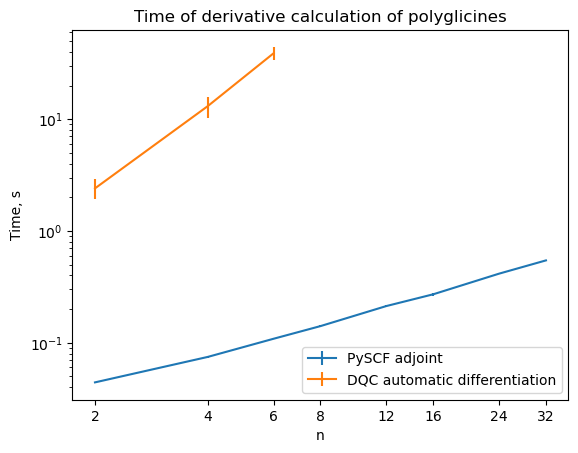

In [62]:
fig, ax = plt.subplots() 

adjoint_x_polyglicines = [l for l in polyglycines_performance['pyscf_adjoint'].keys() if polyglycines_performance['pyscf_adjoint'][l]]
adjoint_y_polyglicines = [l["mean"] for l in polyglycines_performance['pyscf_adjoint'].values() if l]
adjoint_yerr_polyglicines = [l["std_dev"] for l in polyglycines_performance['pyscf_adjoint'].values() if l]
ax.errorbar(adjoint_x_polyglicines, adjoint_y_polyglicines, yerr=adjoint_yerr_polyglicines, label='PySCF adjoint')

dqc_x_polyglicines = [l for l in polyglycines_performance['dqc_onlygrad'].keys() if polyglycines_performance['dqc_onlygrad'][l]]
dqc_y_polyglicines = [l["mean"] for l in polyglycines_performance['dqc_onlygrad'].values() if l]
dqc_yerr_polyglicines = [l["std_dev"] for l in polyglycines_performance['dqc_onlygrad'].values() if l]
ax.errorbar(dqc_x_polyglicines, dqc_y_polyglicines, yerr=dqc_yerr_polyglicines, label='DQC automatic differentiation')

plt.xscale('log')
plt.yscale('log')

plt.title(r"Time of derivative calculation of polyglicines")
plt.xlabel("n")
plt.ylabel("Time, s")

ax.set_xticks(adjoint_x_polyglicines)
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.get_xaxis().set_minor_locator(ticker.NullLocator())

plt.legend(loc='lower right')

plt.show()

In [ ]:
with open('structures/alkanes_molecules.txt') as alkanes_molecules_file: 
    alkanes_molecules_file_as_string = alkanes_molecules_file.read() 

alkanes_molecules = literal_eval(alkanes_molecules_file_as_string)

In [ ]:
alkanes_performance = {
    "pyscf_adjoint":    {},
    "dqc_onlygrad":     {},
}

for data_of_method in alkanes_performance.values():
    for mol_name in alkanes_molecules:
        data_of_method[mol_name] = {}

In [63]:
for mol_name, mol in alkanes_molecules.items():
    print(f"For n-С{mol_name}H{2*mol_name+2}:")

    print("* PySCF 'adjoint':")
    mean, std_dev, all_times = pyscf_adjoint_time_of_derivatives_calculation(mol, LDA_factor, LDA_power)
    alkanes_performance["pyscf_adjoint"][mol_name]["mean"] = mean
    alkanes_performance["pyscf_adjoint"][mol_name]["std_dev"] = std_dev
    print(all_times)

    if mol_name <= 22:
        print("* DQC:")
        mean, std_dev, all_times = dqc_autograd_time_of_derivatives_calculation(mol, LDA_factor, LDA_power)
        alkanes_performance["dqc_onlygrad"][mol_name]["mean"] = mean
        alkanes_performance["dqc_onlygrad"][mol_name]["std_dev"] = std_dev
        print(all_times[0])
        print(all_times[1])
    
    print("---><---")

For n-С4H10:
* PySCF 'adjoint':
29.7 ms ± 1.06 ms per loop (mean ± std. dev. of 100 runs, 10 loops each)
* DQC:
2.32 s ± 131 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
1.72 s ± 71.4 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
---><---
For n-С6H14:
* PySCF 'adjoint':
43 ms ± 46.1 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)
* DQC:
6.65 s ± 222 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
5.23 s ± 173 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
---><---
For n-С8H18:
* PySCF 'adjoint':
56.1 ms ± 1.39 ms per loop (mean ± std. dev. of 100 runs, 10 loops each)
* DQC:
13.4 s ± 464 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
10.8 s ± 396 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
---><---
For n-С10H22:
* PySCF 'adjoint':
69.5 ms ± 1.77 ms per loop (mean ± std. dev. of 100 runs, 10 loops each)
* DQC:
24.5 s ± 686 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)
19.9 s ± 568 ms per loop (mean ± std. dev.

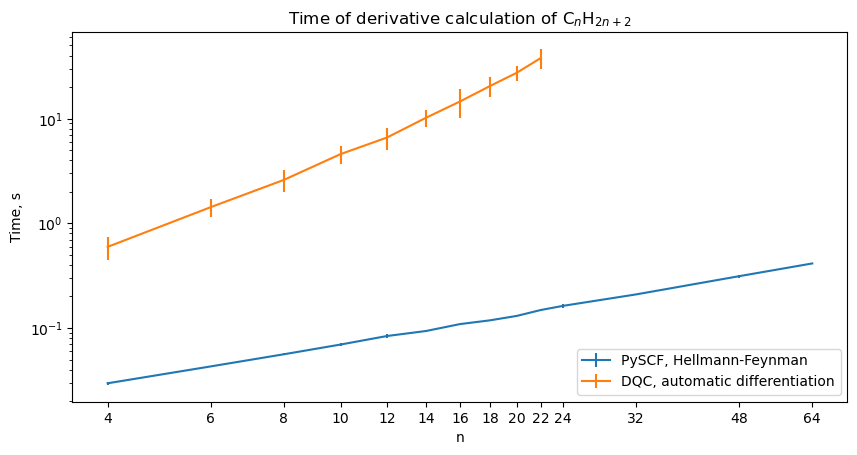

In [72]:
fig, ax = plt.subplots()
fig.set_figwidth(10)

adjoint_x_alkanes = [l for l in alkanes_performance['pyscf_adjoint'].keys() if alkanes_performance['pyscf_adjoint'][l]]
adjoint_y_alkanes = [l["mean"] for l in alkanes_performance['pyscf_adjoint'].values() if l]
adjoint_yerr_alkanes = [l["std_dev"] for l in alkanes_performance['pyscf_adjoint'].values() if l]
ax.errorbar(adjoint_x_alkanes, adjoint_y_alkanes, yerr=adjoint_yerr_alkanes, label='PySCF, Hellmann-Feynman')

dqc_x_alkanes = [l for l in alkanes_performance['dqc_onlygrad'].keys() if alkanes_performance['dqc_onlygrad'][l]]
dqc_y_alkanes = [l["mean"] for l in alkanes_performance['dqc_onlygrad'].values() if l]
dqc_yerr_alkanes = [l["std_dev"] for l in alkanes_performance['dqc_onlygrad'].values() if l]
ax.errorbar(dqc_x_alkanes, dqc_y_alkanes, yerr=dqc_yerr_alkanes, label='DQC, automatic differentiation')

plt.xscale('log')
plt.yscale('log')

plt.title(r"Time of derivative calculation of C$_n$H$_{2n+2}$")
plt.xlabel("n")
plt.ylabel("Time, s")

ax.set_xticks(adjoint_x_alkanes)
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.get_xaxis().set_minor_locator(ticker.NullLocator())

plt.legend(loc='lower right')

plt.savefig('figure.png')

plt.show()